In [29]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

from pymongo import MongoClient


def replace_id(df, replace_name = 'InChI_key'):
    # Load the DataFrame using Polars
    
    # Connect to MongoDB
    client = MongoClient('mongodb://localhost:27017/')
    db = client['lotus_mines']
    
    # Fetch the compounds collection
    compounds_collection = db['compounds']
    
    # Prepare a list to store the results
    results = []
    
    # Iterate over each row in the DataFrame
    for row in df.iter_rows(named=True):
        _id = row['id']
        
        # Find the corresponding compound using _id
        compound = compounds_collection.find_one({'_id': _id})
        
        if compound:
            replace_value = compound.get(replace_name)
            results.append({
                'id': _id,
                replace_name: replace_value
            })
            print(f"Found replace_name: {replace_value} for id: {_id}")
        else:
            print(f"No compound found for id: {_id}")
    
    # Convert the results to a DataFrame
    results_df = pl.DataFrame(results)

    results_df = df.with_columns(results_df[replace_name].alias("id"))
    
    # Display the results
    return results_df


df = pl.read_parquet("../data/MINES/reactions_compounds_list_full.parquet")
df

reaction_id,reactants,products
str,list[struct[2]],list[struct[2]]
"""R5d8539f1d9a5e857189956bad8eb4…","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C878f017efe6de2805a953d0ca9b8491274a29290"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R6a89aaf90529aa474f537c081d71f…","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C54130f1c76aaa5380fa631a6a659121284978c5d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""Rf0c39549766c89963dbb1a98f8f1d…","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""Cfa5e885b86c8c37a465cad5238ed62672498a45d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""Rad931d485dae8cbc9aa07c1301163…","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C57a73b796ef9de341670ad4f895779c4ce0d4623"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R02b3ad62ed7e42f819c6931a7d392…","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C8e1b680b68eec30be34c6b4857d630e2c245759d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
…,…,…
"""Rc52c2d326695e43c104ecd4a11b20…","[{""C92af25813ba38f4e1f385dc92b0e253dc7a01f6c"",""Starting Compound""}]","[{""C5e8022bf3b0f1ee82b5ec45f5c89f69ea2ab5a29"",""Predicted""}, {""X05622481c18728cacf9317e9a57ce6d421315aac"",""Coreactant""}]"
"""Rb993c3707a42c88a143334e22d4af…","[{""C326b3a90bc4bff0d2cf249e40ce517af77a62d0d"",""Starting Compound""}]","[{""Ca4ef9345ff26e4fec21cc7fb72fa9dca2f86fcc5"",""Predicted""}, {""X05622481c18728cacf9317e9a57ce6d421315aac"",""Coreactant""}]"
"""Rc1fdf76ef8f34b7c3a7538fcb9924…","[{""C62f5460835a65fcb75c6c8da0f7f6f90c060d900"",""Starting Compound""}]","[{""Ce9a6758cc6c58ca618292cde869df568a1c34cb8"",""Predicted""}, {""X05622481c18728cacf9317e9a57ce6d421315aac"",""Coreactant""}]"


In [30]:
%%time

# Explode reactants and products
reactants_exploded = df.explode("reactants").select(pl.col(["reaction_id", "reactants"])).unnest("reactants").with_columns(pl.lit(True).alias('reactant'))
products_exploded = df.explode("products").select(pl.col(["reaction_id", "products"])).unnest("products").with_columns(pl.lit(False).alias('reactant'))

reactants_exploded, products_exploded

CPU times: user 8.2 s, sys: 8.27 s, total: 16.5 s
Wall time: 16.3 s


(shape: (7_648_891, 4)
 ┌─────────────────────────────────┬─────────────────────────────────┬───────────────────┬──────────┐
 │ reaction_id                     ┆ id                              ┆ type              ┆ reactant │
 │ ---                             ┆ ---                             ┆ ---               ┆ ---      │
 │ str                             ┆ str                             ┆ str               ┆ bool     │
 ╞═════════════════════════════════╪═════════════════════════════════╪═══════════════════╪══════════╡
 │ R5d8539f1d9a5e857189956bad8eb4… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
 │ R5d8539f1d9a5e857189956bad8eb4… ┆ X0eb45233dd43ecacb9fb1e3114045… ┆ Coreactant        ┆ true     │
 │ R5d8539f1d9a5e857189956bad8eb4… ┆ X8dc023d8052d83fb6feadf8541387… ┆ Coreactant        ┆ true     │
 │ R6a89aaf90529aa474f537c081d71f… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
 │ R6a89aaf90529aa474f537c081d71f… ┆ X0eb45233dd43ecacb9fb1

In [31]:
df_comp = pl.concat([reactants_exploded, products_exploded], how="vertical")  

print(df_comp)

shape: (14_760_171, 4)
┌─────────────────────────────────┬─────────────────────────────────┬───────────────────┬──────────┐
│ reaction_id                     ┆ id                              ┆ type              ┆ reactant │
│ ---                             ┆ ---                             ┆ ---               ┆ ---      │
│ str                             ┆ str                             ┆ str               ┆ bool     │
╞═════════════════════════════════╪═════════════════════════════════╪═══════════════════╪══════════╡
│ R5d8539f1d9a5e857189956bad8eb4… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
│ R5d8539f1d9a5e857189956bad8eb4… ┆ X0eb45233dd43ecacb9fb1e3114045… ┆ Coreactant        ┆ true     │
│ R5d8539f1d9a5e857189956bad8eb4… ┆ X8dc023d8052d83fb6feadf8541387… ┆ Coreactant        ┆ true     │
│ R6a89aaf90529aa474f537c081d71f… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
│ R6a89aaf90529aa474f537c081d71f… ┆ X0eb45233dd43ecacb9fb1e3114045… 

In [4]:
#df_comp.write_parquet("../data/MINES/reactions_compounds_type_reactant_list.parquet")

/tmp/ipykernel_2664491/2141727938.py:7: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  starting_count = starting_compounds.group_by('id').count()


Found replace_name: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O for id: C9ab1a08d72c90a8167d1f3a668d8f1138e534a07
Found replace_name: CO for id: Cf32ec10ed591559703aa6d0857bdee249c4e1a4d
Found replace_name: CC(C)=O for id: Cf29ab8236bcc427a65d62b87ee3f7eb03d824537
Found replace_name: Cl for id: C33faa2b8ca452db82058619ed2de70883482f89d
Found replace_name: O=CO for id: C0e2c8d649fd28524ed617a741b4da1c714899166
Found replace_name: C for id: C3f8881998951e22f122db498b619af1eea58d2c1
Found replace_name: C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O for id: C2b9dd22b6408975452f0865c4ee28ca5254a1adb
Found replace_name: O[C@H]1[C@H](O)[C@H](O)OC[C@H]1O for id: Ca2c5b2bda608fea82809b23867a03096c9d0715c
Found replace_name: C/C=C(/C)C(=O)O for id: C41d99a021c3e0437fb983fa328d642276b2d0f1b
Found replace_name: O=C(O)c1ccccc1 for id: Ce78e822bd39b86bbad3c1f7a4a256c00702cac00
Found replace_name: NC(=O)O for id: C1cff1e0363c01af7dfb5a374f635aecd4ce8e77f
Found replace_name: O=C(O)c1cc(O)c(O)c(O)c1 for id: Cdea41

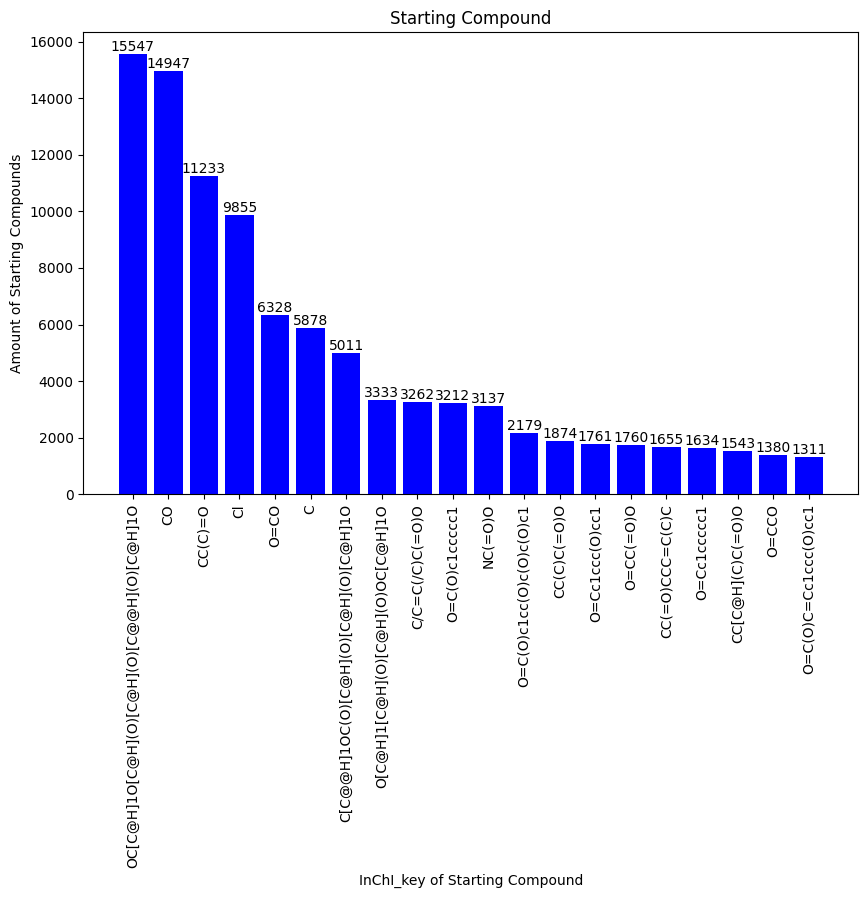

shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ OC[C@H]1O[C@H](O)[C@H](O)[C@@H… ┆ 15547 │
│ CO                              ┆ 14947 │
│ CC(C)=O                         ┆ 11233 │
│ Cl                              ┆ 9855  │
│ O=CO                            ┆ 6328  │
│ …                               ┆ …     │
│ CC(=O)CCC=C(C)C                 ┆ 1655  │
│ O=Cc1ccccc1                     ┆ 1634  │
│ CC[C@H](C)C(=O)O                ┆ 1543  │
│ O=CCO                           ┆ 1380  │
│ O=C(O)C=Cc1ccc(O)cc1            ┆ 1311  │
└─────────────────────────────────┴───────┘


In [32]:
write_fig = True

# Filter data by type
starting_compounds = df_comp.filter(pl.col('type') == 'Starting Compound')

# Count the occurrences of starting compounds for each starting compound ID
starting_count = starting_compounds.group_by('id').count()
starting_count = starting_count.sort('count', descending=True)

#starting_count = replace_id(starting_count[0:20], replace_name="structure_nameTraditional" )
starting_count = replace_id(starting_count[0:20], replace_name="SMILES" )

# Add the numbers on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(starting_count['id'], starting_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Starting Compound')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/starting_compounds_top_20_barplot.png')

plt.show()

print(starting_count)

/tmp/ipykernel_2664491/1180207238.py:6: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  predicted_count = predicted_compounds.group_by('id').count()


Found replace_name: Br for id: Cf832df7e99cab85f81bb00bc985412d7cf424409
Found replace_name: O=S(=O)(O)OO for id: Cbeafbb8f579e289f50a66a2be4f2bfc232c02d6f
Found replace_name: OC[C@@]1(O)CO[C@@H](O)[C@@H]1O for id: C8ae480eb6c254b8a90818fcaffb6c7d6c8b74139
Found replace_name: CC(C)(O)C=O for id: Ca3a0ad590f8aeb7045f5e92cf9f1d84377f98d15
Found replace_name: COC(=O)C=O for id: C84cb2f7e765ed6494b6650a2615fc08606587f8a
Found replace_name: CC(C)C for id: Cbb4e00526d0f100dd7a79df741588c6836094166
Found replace_name: C=C(C)C for id: C9ff2db8c112a1f93552bf1d2deef8310b8ca96b9
Found replace_name: CCCCC/C=C/CC=O for id: C226f0027de99ad0af9ba3423b1faacc62117cab0
Found replace_name: C[C@@H]1O[C@@H](O[C@H]2[C@@H](O)[C@@H](O)[C@H](O)O[C@@H]2CO)[C@H](O)[C@H](O)[C@H]1O for id: Cf76eabd9f5b274e726753ccdff946386006aff0c
Found replace_name: F for id: Cbe7d8c1f20311b2e2093befdee25a421c4c961e1
Found replace_name: CC(C)[C@@H](C)C=O for id: C65ee428fd4dd70b3764b1e3c36c414bd147b4678
Found replace_name: CC(=O)

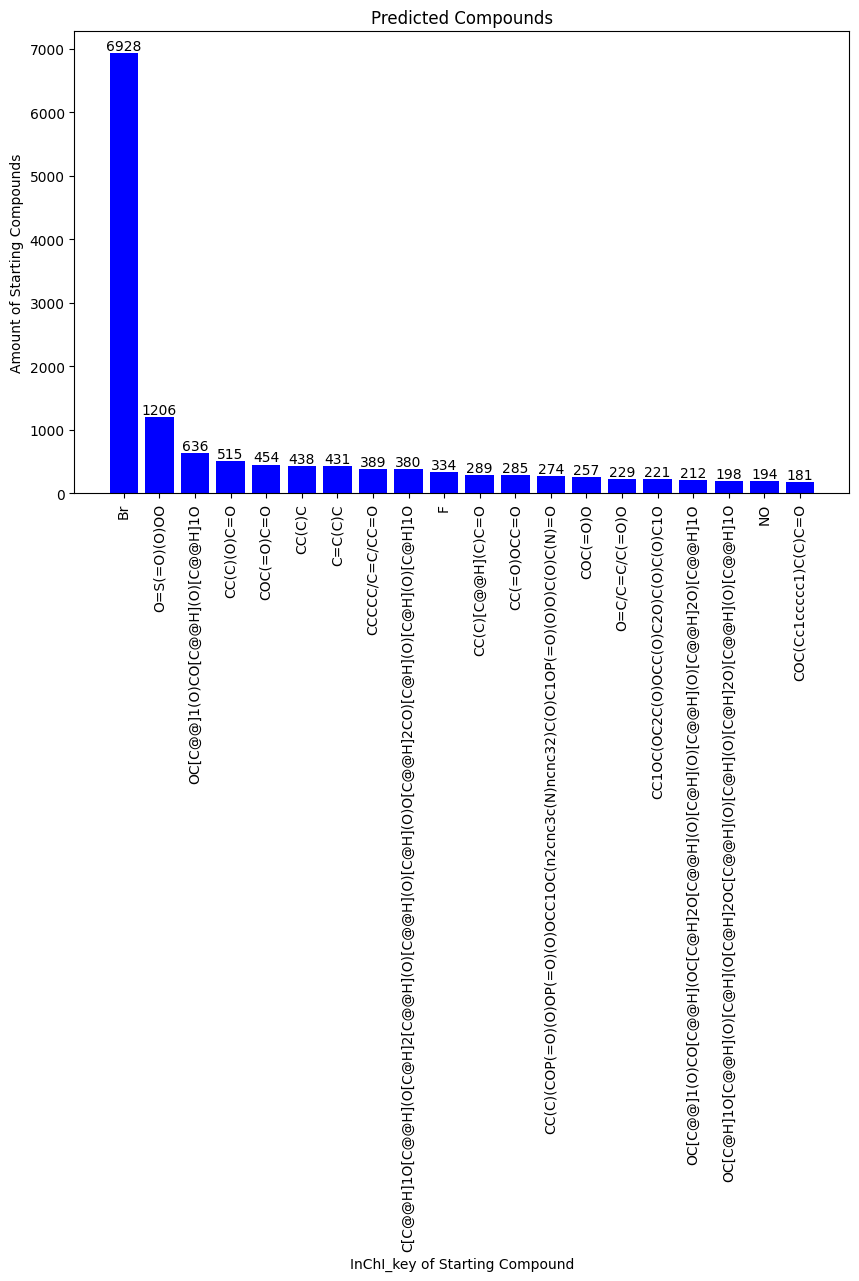

shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Br                              ┆ 6928  │
│ O=S(=O)(O)OO                    ┆ 1206  │
│ OC[C@@]1(O)CO[C@@H](O)[C@@H]1O  ┆ 636   │
│ CC(C)(O)C=O                     ┆ 515   │
│ COC(=O)C=O                      ┆ 454   │
│ …                               ┆ …     │
│ CC1OC(OC2C(O)OCC(O)C2O)C(O)C(O… ┆ 221   │
│ OC[C@@]1(O)CO[C@@H](OC[C@H]2O[… ┆ 212   │
│ OC[C@H]1O[C@@H](O)[C@H](O[C@H]… ┆ 198   │
│ NO                              ┆ 194   │
│ COC(Cc1ccccc1)C(C)C=O           ┆ 181   │
└─────────────────────────────────┴───────┘


In [26]:
write_fig = True

predicted_compounds = df_comp.filter(pl.col('type') == 'Predicted')

# Count the occurrences of predicted compounds for each starting compound ID
predicted_count = predicted_compounds.group_by('id').count()
predicted_count = predicted_count.sort('count', descending=True)

predicted_count = replace_id(predicted_count[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_count['id'], predicted_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Predicted Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/predicted_compounds_top_20_barplot.png')

plt.show()

print(predicted_count)

In [11]:
df = df_comp

# Grouping and aggregating
result = (
    df.group_by("reaction_id")
    .agg([
        pl.when(pl.col("type") == "Coreactant").then(pl.col("id")).otherwise(None).alias("coreactant"),
        pl.when(pl.col("type") == "Starting Compound").then(pl.col("id")).otherwise(None).alias("starting_compound"),
        pl.when(pl.col("type") == "Predicted").then(pl.col("id")).otherwise(None).alias("predicted")
    ])
)

# Function to remove null values from a list
def remove_nulls(lst):
    return [x for x in lst if x is not None]

# Apply the function to each list column with specified return_dtype
df_cleaned = result.with_columns([
    pl.col("coreactant").apply(remove_nulls, return_dtype=pl.List(pl.Utf8)).alias("coreactant"),
    pl.col("starting_compound").apply(remove_nulls, return_dtype=pl.List(pl.Utf8)).alias("starting_compound"),
    pl.col("predicted").apply(remove_nulls, return_dtype=pl.List(pl.Utf8)).alias("predicted")
])

print(df_cleaned)

# Display the rebsult
print(result)

AttributeError: 'Expr' object has no attribute 'apply'

### starting and predicted compounds plots with real counts

In [27]:
%%time

df2 = pl.read_parquet("../data/MINES/reactions_compounds_list_with_counts.parquet")

# Explode reactants and products
reactants_exploded = df2.explode("reactants").select(pl.col(["reaction_id", "reactants"])).unnest("reactants").with_columns(pl.lit(True).alias('reactant'))
products_exploded = df2.explode("products").select(pl.col(["reaction_id", "products"])).unnest("products").with_columns(pl.lit(False).alias('reactant'))

df_comp2 = pl.concat([reactants_exploded, products_exploded], how="vertical")  

df_comp2

CPU times: user 13.7 s, sys: 11.4 s, total: 25.1 s
Wall time: 21.5 s


reaction_id,id,type,count,reactant
str,str,str,i64,bool
"""R5d8539f1d9a5e857189956bad8eb4…","""Ce8bc5cd3aa30776ab6d35fdc2bcc4…","""Starting Compound""",2,true
"""R5d8539f1d9a5e857189956bad8eb4…","""X0eb45233dd43ecacb9fb1e3114045…","""Coreactant""",1,true
"""R5d8539f1d9a5e857189956bad8eb4…","""X8dc023d8052d83fb6feadf8541387…","""Coreactant""",1,true
"""R6a89aaf90529aa474f537c081d71f…","""Ce8bc5cd3aa30776ab6d35fdc2bcc4…","""Starting Compound""",2,true
"""R6a89aaf90529aa474f537c081d71f…","""X0eb45233dd43ecacb9fb1e3114045…","""Coreactant""",1,true
…,…,…,…,…
"""Rc1fdf76ef8f34b7c3a7538fcb9924…","""X05622481c18728cacf9317e9a57ce…","""Coreactant""",1,false
"""Rbe1a7403def3e4c0a1dac139d28a0…","""C58fecaa1205bf8dee7e07040978bc…","""Starting Compound""",1,false
"""Rbe1a7403def3e4c0a1dac139d28a0…","""X05622481c18728cacf9317e9a57ce…","""Coreactant""",1,false


Found replace_name: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O for id: C9ab1a08d72c90a8167d1f3a668d8f1138e534a07
Found replace_name: CO for id: Cf32ec10ed591559703aa6d0857bdee249c4e1a4d
Found replace_name: CC(C)=O for id: Cf29ab8236bcc427a65d62b87ee3f7eb03d824537
Found replace_name: Cl for id: C33faa2b8ca452db82058619ed2de70883482f89d
Found replace_name: O=CO for id: C0e2c8d649fd28524ed617a741b4da1c714899166
Found replace_name: C for id: C3f8881998951e22f122db498b619af1eea58d2c1
Found replace_name: C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O for id: C2b9dd22b6408975452f0865c4ee28ca5254a1adb
Found replace_name: O[C@H]1[C@H](O)[C@H](O)OC[C@H]1O for id: Ca2c5b2bda608fea82809b23867a03096c9d0715c
Found replace_name: C/C=C(/C)C(=O)O for id: C41d99a021c3e0437fb983fa328d642276b2d0f1b
Found replace_name: O=C(O)c1ccccc1 for id: Ce78e822bd39b86bbad3c1f7a4a256c00702cac00
Found replace_name: NC(=O)O for id: C1cff1e0363c01af7dfb5a374f635aecd4ce8e77f
Found replace_name: O=C(O)c1cc(O)c(O)c(O)c1 for id: Cdea41

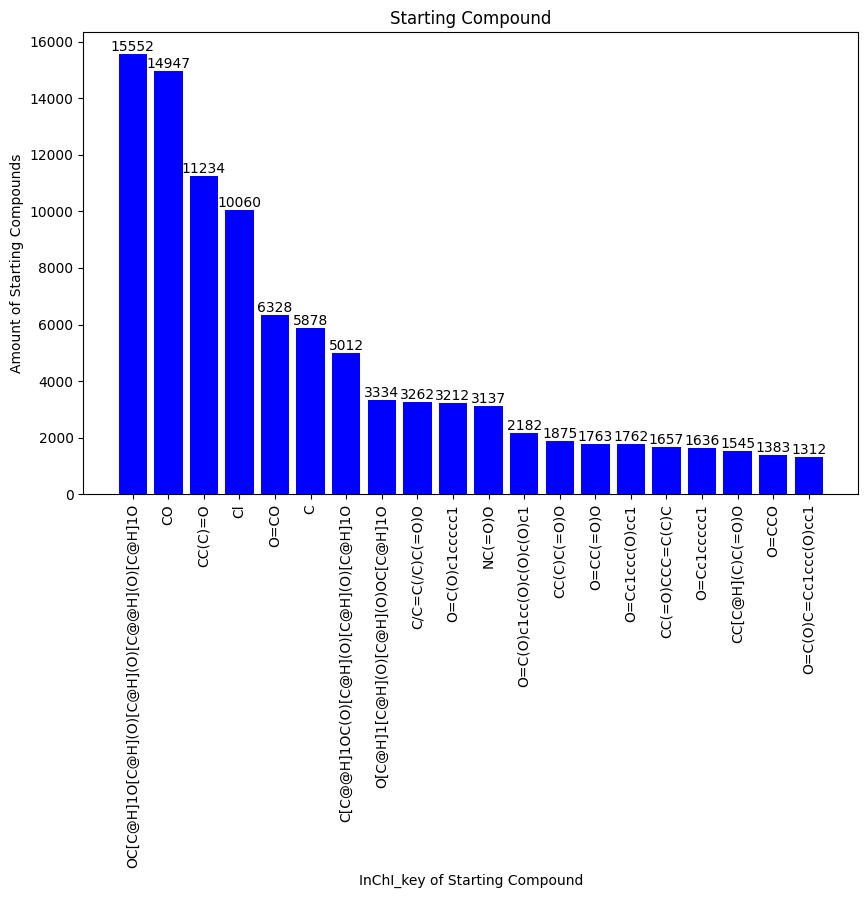

shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ i64   │
╞═════════════════════════════════╪═══════╡
│ OC[C@H]1O[C@H](O)[C@H](O)[C@@H… ┆ 15552 │
│ CO                              ┆ 14947 │
│ CC(C)=O                         ┆ 11234 │
│ Cl                              ┆ 10060 │
│ O=CO                            ┆ 6328  │
│ …                               ┆ …     │
│ CC(=O)CCC=C(C)C                 ┆ 1657  │
│ O=Cc1ccccc1                     ┆ 1636  │
│ CC[C@H](C)C(=O)O                ┆ 1545  │
│ O=CCO                           ┆ 1383  │
│ O=C(O)C=Cc1ccc(O)cc1            ┆ 1312  │
└─────────────────────────────────┴───────┘


In [28]:
write_fig = True

# Filter data by type
starting_compounds = df_comp2.filter(pl.col('type') == 'Starting Compound')

# Count the occurrences of starting compounds for each starting compound ID
starting_count = starting_compounds.group_by('id').agg(pl.col('count').sum())

starting_count = starting_count.sort('count', descending=True)

#starting_count = replace_id(starting_count[0:20], replace_name="structure_nameTraditional" )
starting_count = replace_id(starting_count[0:20], replace_name="SMILES" )

# Add the numbers on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(starting_count['id'], starting_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Starting Compound')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/starting_compounds_top_20_barplot_counts.png')

plt.show()

print(starting_count)

In [ ]:
write_fig = True

predicted_compounds = df_comp2.filter(pl.col('type') == 'Predicted')

# Count the occurrences of predicted compounds for each starting compound ID
predicted_count = predicted_compounds.group_by('id').count()
predicted_count = predicted_count.sort('count', descending=True)

predicted_count = replace_id(predicted_count[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_count['id'], predicted_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Predicted Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/predicted_compounds_top_20_barplot_counts.png')

plt.show()

print(predicted_count)